In [1]:
# Importing Libraries and Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import yfinance as yf

In [2]:
# Load in 2min SPY data and preview data 

ticker = ['SPY'] #Change ticker symbol to review any instrument in yahoo finance 
data_df = yf.download(ticker, interval = '2m', start = "2022-09-19", end = "2022-11-04")
# 2 min data only available in last 60 days 

data = data_df.drop(columns = ['Volume', 'Open', 'High', 'Low', 'Adj Close'])
data.head()

[*********************100%***********************]  1 of 1 completed


,Close
Datetime,
2022-09-26 09:30:00,367.369995
2022-09-26 09:32:00,367.869995
2022-09-26 09:34:00,368.089996
2022-09-26 09:36:00,368.220001
2022-09-26 09:38:00,367.894989


In [3]:
# Review dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5649 entries, 2022-09-26 09:30:00 to 2022-11-03 15:58:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5649 non-null   float64
dtypes: float64(1)
memory usage: 88.3 KB


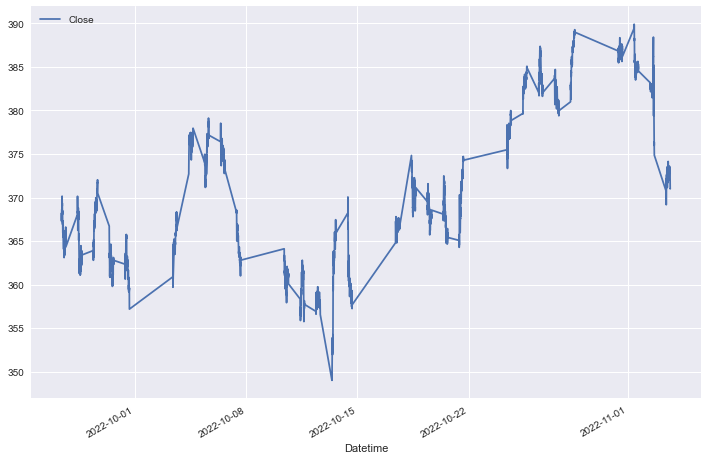

In [4]:
# Plot buy and hold returns strategy 

data.plot(figsize = (12, 8))
plt.show()

In [5]:
# Use shift function to create a column for returns and review 
#data["returns"] = np.log(data.div(data.shift(1)))
data['daily_returns'] = data.Close.pct_change()
data.head()

,Close,daily_returns
Datetime,,
2022-09-26 09:30:00,367.369995,NaN
2022-09-26 09:32:00,367.869995,0.001361
2022-09-26 09:34:00,368.089996,0.000598
2022-09-26 09:36:00,368.220001,0.000353
2022-09-26 09:38:00,367.894989,-0.000883


In [6]:
# Bollinger Bands Trading Strategy 

# Set SMA and standard deviations 
SMA = 30
dev = 2


# Creating column to hold SMA
data["SMA"] = data["Close"].rolling(SMA).mean()

# Creating the lower band 
data["Lower"] = data["SMA"] - data["Close"].rolling(SMA).std() * dev 

# Creating the upper band
data["Upper"] = data["SMA"] + data["Close"].rolling(SMA).std() * dev 

# Creating a column for distance between closing price and the SMA
data["distance"] = data.Close - data.SMA # helper Column

# Creating a column to add a 1 if oversold to go long 
data["position"] = np.where(data.Close < data.Lower, 1, np.nan) # 1. oversold -> go long

# Adding a -1 to the 'position' row if overbought to go short 
data["position"] = np.where(data.Close > data.Upper, -1, data["position"]) # 2. overbought -> go short

# Adding a 0 to the 'position' column to close position when passes SMA 
data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])

# If 1-3 isn't met the previous position is held 
data["position"] = data.position.ffill().fillna(0) # where 1-3 isn´t applicable -> hold previous position

# Creating a column for strategy returns
data["strategy_returns"] = data.position.shift(1) * data["daily_returns"]

In [7]:
data.dropna(inplace=True)

In [8]:
data.head()

,Close,daily_returns,SMA,Lower,Upper,distance,position,strategy_returns
Datetime,,,,,,,,
2022-09-26 10:28:00,369.820007,0.000351,368.531830,366.846767,370.216893,1.288177,0.0,0.0
2022-09-26 10:30:00,369.570099,-0.000676,368.605167,366.937928,370.272405,0.964932,0.0,-0.0
2022-09-26 10:32:00,369.390015,-0.000487,368.655834,366.988658,370.323010,0.734181,0.0,-0.0
2022-09-26 10:34:00,369.011108,-0.001026,368.686538,367.028580,370.344496,0.324571,0.0,-0.0
2022-09-26 10:36:00,369.359985,0.000945,368.724537,367.058589,370.390485,0.635448,0.0,0.0


In [9]:
from math import floor 
from termcolor import colored as cl
spy_ret = pd.DataFrame(np.diff(data['Close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []

for i in range(len(spy_ret)):
    returns = spy_ret['returns'][i]*data['position'][i]
    bb_strategy_ret.append(returns)
bb_strat_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0: 'bb_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/data['Close'][-1])
bb_investment_ret = []

for i in range(len(bb_strat_df['bb_returns'])):
    returns = number_of_stocks*bb_strat_df['bb_returns'][i]
    bb_investment_ret.append(returns)

bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(columns = {0: 'investment_returns'})
total_investment_ret = round(sum(bb_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)

print(cl('Profit gained from the BB strategy by investing $100k in SPY : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the BB strategy : {}%'.format(profit_percentage), attrs = ['bold']))
annualized_return = bb_strat_df['bb_returns'].mean() * 252
annualized_std = bb_strat_df['bb_returns'].std() * np.sqrt(252)
sharpe = annualized_return / annualized_std
print(sharpe)

Profit gained from the BB strategy by investing $100k in SPY : 7968.92
Profit percentage of the BB strategy : 7%
0.24932173756421366


In [10]:
data["cum_returns"] = data["daily_returns"].cumsum().apply(np.exp)
data["cum_return_strategy"] = data["strategy_returns"].cumsum().apply(np.exp)

In [11]:
annualized_return = data["daily_returns"]

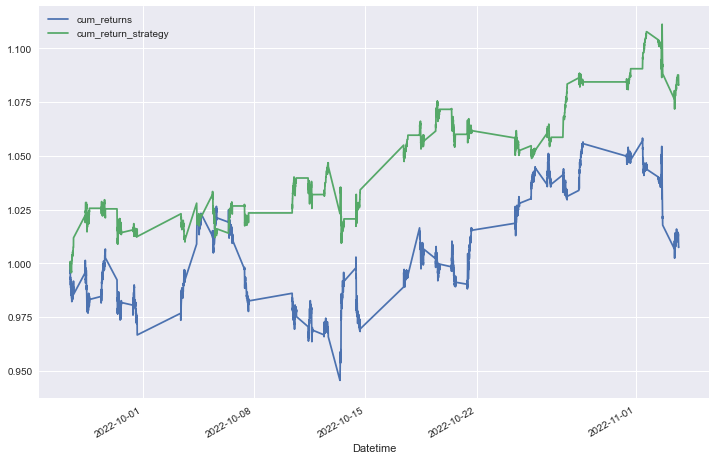

In [12]:
data[["cum_returns", "cum_return_strategy"]].plot(figsize = (12 , 8))
plt.show()

In [13]:
data.tail()

,Close,daily_returns,SMA,Lower,Upper,distance,position,strategy_returns,cum_returns,cum_return_strategy
Datetime,,,,,,,,,,
2022-11-03 15:50:00,371.635010,-0.000954,372.955070,372.036920,373.873220,-1.320060,1.0,-0.000954,1.009157,1.084711
2022-11-03 15:52:00,371.420013,-0.000579,372.890071,371.828567,373.951574,-1.470057,1.0,-0.000579,1.008573,1.084084
2022-11-03 15:54:00,371.225006,-0.000525,372.828571,371.608292,374.048849,-1.603564,1.0,-0.000525,1.008043,1.083515
2022-11-03 15:56:00,370.990112,-0.000633,372.745241,371.379151,374.111331,-1.755129,1.0,-0.000633,1.007406,1.082829
2022-11-03 15:58:00,371.010010,0.000054,372.661335,371.188906,374.133764,-1.651325,1.0,0.000054,1.007460,1.082887


In [14]:
data_test = pd.DataFrame(data['Close'])
data_test.to_csv('df.csv')

In [15]:
from itertools import product
import MeanRevBacktester as MeanRev
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import yfinance as yf

In [16]:
trading_costs = 0.00007

In [17]:
tester = MeanRev.MeanRevBacktester('Close', 30, 2, "2022-09-19", "2022-11-04", trading_costs)

In [18]:
tester

MeanRevBacktester(symbol = Close, SMA = 30, dev = 2, start = 2022-09-19, end = 2022-11-04)

In [19]:
tester.test_strategy()

(1.0, 0.032569)

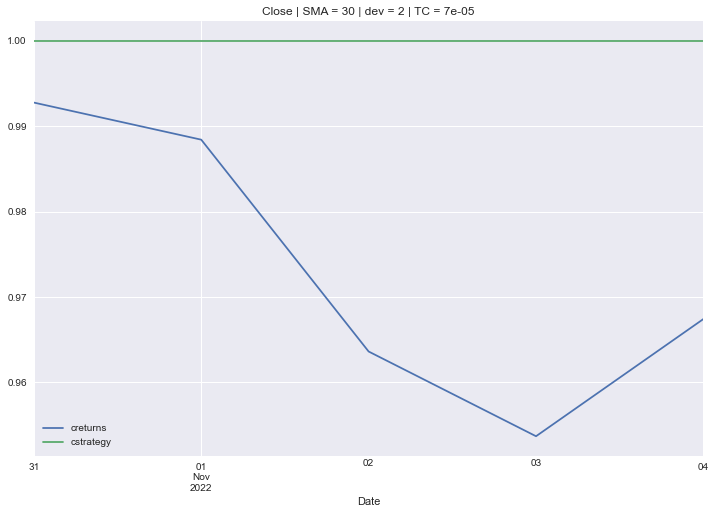

In [20]:
tester.plot_results()

In [21]:
tester.optimize_parameters((25, 100, 1), (1, 5, 1))

IndexError: single positional indexer is out-of-bounds

In [ ]:
tester.plot_results()

In [ ]:
tester.results

In [22]:
tester.results_overview

AttributeError: 'MeanRevBacktester' object has no attribute 'results_overview'

In [23]:
tester.results_overview.nlargest(10, "performance")

AttributeError: 'MeanRevBacktester' object has no attribute 'results_overview'

In [24]:
tester.results_overview.nsmallest(10, "performance")

AttributeError: 'MeanRevBacktester' object has no attribute 'results_overview'

In [25]:
## Machine Learning (Model 1)

In [26]:
#display df from investing strategy
display(data.head(5))
display(data.tail(5))

,Close,daily_returns,SMA,Lower,Upper,distance,position,strategy_returns,cum_returns,cum_return_strategy
Datetime,,,,,,,,,,
2022-09-26 10:28:00,369.820007,0.000351,368.531830,366.846767,370.216893,1.288177,0.0,0.0,1.000351,1.0
2022-09-26 10:30:00,369.570099,-0.000676,368.605167,366.937928,370.272405,0.964932,0.0,-0.0,0.999676,1.0
2022-09-26 10:32:00,369.390015,-0.000487,368.655834,366.988658,370.323010,0.734181,0.0,-0.0,0.999189,1.0
2022-09-26 10:34:00,369.011108,-0.001026,368.686538,367.028580,370.344496,0.324571,0.0,-0.0,0.998164,1.0
2022-09-26 10:36:00,369.359985,0.000945,368.724537,367.058589,370.390485,0.635448,0.0,0.0,0.999108,1.0


,Close,daily_returns,SMA,Lower,Upper,distance,position,strategy_returns,cum_returns,cum_return_strategy
Datetime,,,,,,,,,,
2022-11-03 15:50:00,371.635010,-0.000954,372.955070,372.036920,373.873220,-1.320060,1.0,-0.000954,1.009157,1.084711
2022-11-03 15:52:00,371.420013,-0.000579,372.890071,371.828567,373.951574,-1.470057,1.0,-0.000579,1.008573,1.084084
2022-11-03 15:54:00,371.225006,-0.000525,372.828571,371.608292,374.048849,-1.603564,1.0,-0.000525,1.008043,1.083515
2022-11-03 15:56:00,370.990112,-0.000633,372.745241,371.379151,374.111331,-1.755129,1.0,-0.000633,1.007406,1.082829
2022-11-03 15:58:00,371.010010,0.000054,372.661335,371.188906,374.133764,-1.651325,1.0,0.000054,1.007460,1.082887


In [27]:
# Assign X variable to SMA, Lower, Upper (Maybe just distance)
X = data[["SMA", "distance"]].copy()

display(X)

,SMA,distance
Datetime,,
2022-09-26 10:28:00,368.531830,1.288177
2022-09-26 10:30:00,368.605167,0.964932
2022-09-26 10:32:00,368.655834,0.734181
2022-09-26 10:34:00,368.686538,0.324571
2022-09-26 10:36:00,368.724537,0.635448
...,...,...
2022-11-03 15:50:00,372.955070,-1.320060
2022-11-03 15:52:00,372.890071,-1.470057
2022-11-03 15:54:00,372.828571,-1.603564


In [28]:
# Assign the y variable to position
y = data[["position"]].copy()

display(y)

,position
Datetime,
2022-09-26 10:28:00,0.0
2022-09-26 10:30:00,0.0
2022-09-26 10:32:00,0.0
2022-09-26 10:34:00,0.0
2022-09-26 10:36:00,0.0
...,...
2022-11-03 15:50:00,1.0
2022-11-03 15:52:00,1.0
2022-11-03 15:54:00,1.0


In [29]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [30]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2022-09-26 10:28:00


In [31]:
# Select the ending period for the training data with an offset of 4 months
training_end = X.index.min() + DateOffset(days=4)

# Display the training end date
print(training_end)

2022-09-30 10:28:00


In [32]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]
X_train.head()

,SMA,distance
Datetime,,
2022-09-26 10:28:00,368.531830,1.288177
2022-09-26 10:30:00,368.605167,0.964932
2022-09-26 10:32:00,368.655834,0.734181
2022-09-26 10:34:00,368.686538,0.324571
2022-09-26 10:36:00,368.724537,0.635448


In [33]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())
display(X_test.tail())

,SMA,distance
Datetime,,
2022-09-30 10:28:00,362.336375,0.713613
2022-09-30 10:30:00,362.372542,1.047471
2022-09-30 10:32:00,362.428876,1.861133
2022-09-30 10:34:00,362.498709,1.526285
2022-09-30 10:36:00,362.627709,1.872291


,SMA,distance
Datetime,,
2022-11-03 15:50:00,372.955070,-1.320060
2022-11-03 15:52:00,372.890071,-1.470057
2022-11-03 15:54:00,372.828571,-1.603564
2022-11-03 15:56:00,372.745241,-1.755129
2022-11-03 15:58:00,372.661335,-1.651325


In [34]:
# Imports
from sklearn.preprocessing import StandardScaler

In [35]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [49]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import zero_one_loss

In [37]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

/Users/hunterspence/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1., -1., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.])

In [38]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.80      0.82      0.81       239
         0.0       0.74      0.81      0.77       340
         1.0       0.90      0.74      0.81       202

    accuracy                           0.79       781
   macro avg       0.81      0.79      0.80       781
weighted avg       0.80      0.79      0.79       781



In [39]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [40]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.54      0.53      1423
         0.0       0.61      0.38      0.47      2130
         1.0       0.37      0.59      0.46      1287

    accuracy                           0.48      4840
   macro avg       0.50      0.50      0.49      4840
weighted avg       0.52      0.48      0.48      4840



In [51]:
zero_loss = zero_one_loss(y_train, training_signal_predictions)
print(zero_loss)

0.2074263764404609


In [52]:
zero_loss2 = zero_one_loss(y_test, testing_signal_predictions)
print(zero_loss2)

0.5169421487603305


In [57]:
# Create a close DataFrame
data_close = data["Close"].copy()
close_time = data_close.loc[training_begin:training_end]
# Create a new empty predictions DataFrame
predictions_df = y_train.copy()
predictions_df = predictions_df.drop(columns = ['position'])
predictions_df["ml_returns"] = 0
predictions_df["predicted_signal"] = training_signal_predictions
predictions_df["Close"] = close_time
# Display DF
display(predictions_df.head())
display(predictions_df.tail())

,ml_returns,predicted_signal,Close
Datetime,,,
2022-09-26 10:28:00,0,-1.0,369.820007
2022-09-26 10:30:00,0,-1.0,369.570099
2022-09-26 10:32:00,0,-1.0,369.390015
2022-09-26 10:34:00,0,0.0,369.011108
2022-09-26 10:36:00,0,-1.0,369.359985


,ml_returns,predicted_signal,Close
Datetime,,,
2022-09-30 10:20:00,0,0.0,362.234985
2022-09-30 10:22:00,0,0.0,362.570007
2022-09-30 10:24:00,0,-1.0,363.149994
2022-09-30 10:26:00,0,0.0,362.549988
2022-09-30 10:28:00,0,-1.0,363.049988


-1.7980815374059045


None

In [42]:
from math import floor 
from termcolor import colored as cl
spy_ret = pd.DataFrame(np.diff(predictions_df['Close'])).rename(columns = {0 :'returns'})
ml_strategy_ret = []

for i in range(len(spy_ret)):
    returns = spy_ret['returns'][i]*predictions_df['predicted_signal'][i]
    ml_strategy_ret.append(returns)
ml_strat_df = pd.DataFrame(ml_strategy_ret).rename(columns = {0: 'ml_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/predictions_df['Close'][-1])
ml_investment_ret = []

for i in range(len(ml_strat_df['ml_returns'])):
    returns = number_of_stocks*ml_strat_df['ml_returns'][i]
    ml_investment_ret.append(returns)

ml_investment_ret_df = pd.DataFrame(ml_investment_ret).rename(columns = {0: 'investment_returns'})
total_investment_ret = round(sum(ml_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)

print(cl('Profit gained from the ML strategy by investing $100k in SPY : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of ML strategy : {}%'.format(profit_percentage), attrs = ['bold']))
    
annualized_return2 = ml_strat_df['ml_returns'].mean() * 252
annualized_std2 = ml_strat_df['ml_returns'].std() * np.sqrt(252)
sharpe = annualized_return / annualized_std
print(sharpe.mean())

Profit gained from the ML strategy by investing $100k in SPY : 3379.71
Profit percentage of ML strategy : 3%
2.4817084914992053e-07


In [ ]:
#ML model 2